# Monocular Depth Estimation - Pix2Pix
We explore the application of Pix2Pix, a conditional Generative Adversarial Network (GAN), for the task of monocular depth estimation.
Monocular depth estimation involves predicting depth information from a single RGB image, and Pix2Pix can be employed as a deep learning approach to tackle this challenging computer vision problem.

## Setting up the environment

In [1]:
!pip install --upgrade tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/packages/d1/1d/d5cf76e5e40f69dbd273036e3172ae4a614577cb141673427b80cac948df/ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.8 MB/s eta 0:00:00
  Obtaining dependency information for tensorboard<2.15,>=2.14 from https://files.pythonhosted.org/packages/73/a2/66ed644f6ed1562e0285fcd959af17670ea313c8f331c46f79ee77187eb9/tensorboard-2.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-estimator<2.15,>=2.14.0 from https://files.pythonhosted.org/packages/d1/da/4f264c196325bb6e37a6285caec5b12a03def489b57cc1fdac02bb6272cd/tensorflow_est

In [2]:
import tensorflow as tf
import numpy as np

import os
import cv2
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
from PIL import Image

2023-11-10 07:05:00.704408: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 07:05:00.704469: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 07:05:00.704509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preparing the Dataset

In [3]:
DATASET_DIRECTORY = '/kaggle/input/monocular-depth-estimation/val/indoors'

dataset = {}
for subdir, dirs, files in os.walk(DATASET_DIRECTORY):
  for file in files:
    basename = os.path.basename(os.path.join(subdir, file))
    if basename[-3:] == "png":
      basename = basename[:-4]
      kind = "rgb"
    elif basename[-9:] == "depth.npy":
      basename = basename[:-10]
      kind = "depth"
    elif basename[-14:] == "depth_mask.npy":
      basename = basename[:-15]
      kind = "mask"
    else:
      continue

    if not basename in dataset:
      dataset[basename] = { "rgb": None, "depth": None, "mask": None }
    dataset[basename][kind] = os.path.join(subdir, file)

for name in [
    '00020_00186_indoors_330_010',
    '00020_00186_indoors_340_000',
    '00020_00186_indoors_320_000',
    '00019_00183_indoors_320_030',
    '00020_00186_indoors_080_010',
    '00020_00186_indoors_170_040',
    '00021_00190_indoors_290_010',
    '00019_00183_indoors_170_000',
    '00020_00185_indoors_000_020']:
    print("Removing:", name)
    dataset.pop(name, None)

Removing: 00020_00186_indoors_330_010
Removing: 00020_00186_indoors_340_000
Removing: 00020_00186_indoors_320_000
Removing: 00019_00183_indoors_320_030
Removing: 00020_00186_indoors_080_010
Removing: 00020_00186_indoors_170_040
Removing: 00021_00190_indoors_290_010
Removing: 00019_00183_indoors_170_000
Removing: 00020_00185_indoors_000_020


In [4]:
def load(name: str):
  name = name
  rgb = dataset[name]["rgb"]
  rgb = tf.io.read_file(rgb)
  rgb = tf.io.decode_png(rgb)
  rgb = tf.image.convert_image_dtype(rgb, np.float32)
  rgb = ((rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb)))


  depth = dataset[name]["depth"]
  depth = np.load(depth).squeeze()

  mask = dataset[name]["mask"]
  mask = np.load(mask)
  mask = mask > 0

  max_depth = min(300, np.percentile(depth, 99))
  depth = np.clip(depth, 0.1, max_depth)
  depth = np.log(depth, where=mask)
  depth = np.ma.masked_where(~mask, depth)
  depth = np.clip(depth, 0.1, np.log(max_depth))
  depth = np.expand_dims(depth, axis=2)
  depth = np.concatenate([depth] * 3, axis=2)
  depth = ((depth - np.min(depth)) / (np.max(depth) - np.min(depth)))
  depth = tf.cast(depth, tf.float32)

  return rgb, depth

In [5]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [6]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [7]:
def normalize(input_image, real_image):
  input_image = (input_image * 2) - 1
  real_image = (real_image * 2) - 1

  return input_image, real_image

In [8]:
def denormalize(image):
  input_image = (image + 1) / 2

  return image

In [9]:
@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)

  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [10]:
def load_image_train(image_file):
  image_file = bytes.decode(image_file.numpy())

  input_image, real_image = load(image_file)
  input_image, real_image = normalize(input_image, real_image)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)

  return input_image, real_image

In [11]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Hyperparameters

In [12]:
BUFFER_SIZE     = 325
BATCH_SIZE      = 8
IMG_WIDTH       = 256
IMG_HEIGHT      = 256
OUTPUT_CHANNELS = 3
NUM_STEPS       = 10000

In [13]:
rgb, depth = load('00019_00183_indoors_000_010')
rgb, depth = resize(rgb, depth, IMG_HEIGHT, IMG_WIDTH)
rgb, depth = normalize(rgb, depth)

In [14]:
files = list(dataset.keys())
train_dataset = tf.data.Dataset.from_tensor_slices(files)
train_dataset = train_dataset.map(lambda x: tf.py_function(load_image_train, [x], [tf.float32, tf.float32]),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [16]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [17]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [19]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [20]:
generator = Generator()
discriminator = Discriminator()

In [21]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

In [22]:
generator_optimizer = tf.keras.optimizers.Adadelta(2e-6)
discriminator_optimizer = tf.keras.optimizers.Adadelta(2e-6)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  for i in range(3):
    display_list[i] = display_list[i] * 0.5 + 0.5
  title = ['RGB Image', 'Depth Image', 'Predicted Image']

    
  plt.subplot(1, 3, 1)
  plt.title('RGB Image')
  plt.imshow(display_list[0])
  plt.axis('off')
             
  plt.subplot(1, 3, 2)
  plt.title('Depth (Real) Image')
  plt.imshow(display_list[1][:,:,0], cmap='plasma')
  plt.axis('off')
             
  plt.subplot(1, 3, 3)
  plt.title('Depth (Estimated) Image')
  plt.imshow(display_list[2][:,:,0], cmap='plasma')
  plt.axis('off')

  plt.show()

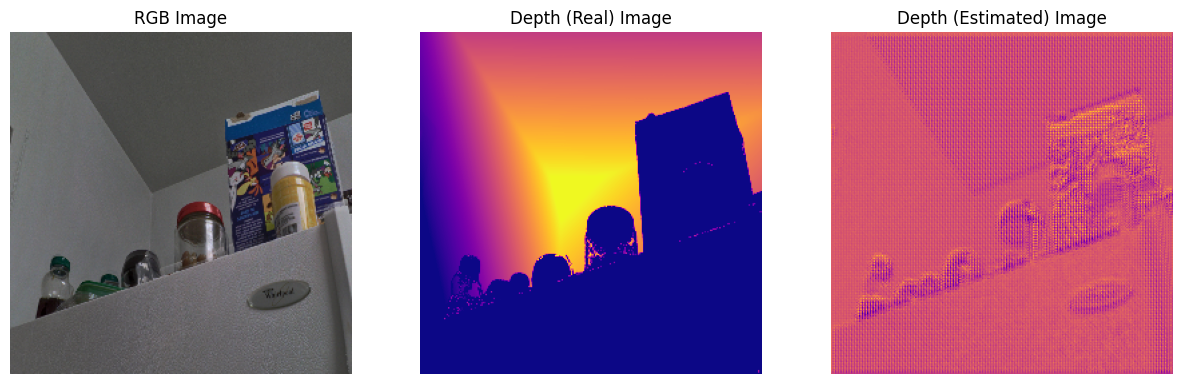

In [25]:
for example_input, example_target in train_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [26]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [27]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
    
  return [gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss]

In [28]:
def fit(train_ds, test_ds, steps):
  losses = []
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    loss = train_step(input_image, target, step)
    losses.append(loss)

    # Training step
    if (step+1) % 10 == 0:
      print('#', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
  return losses

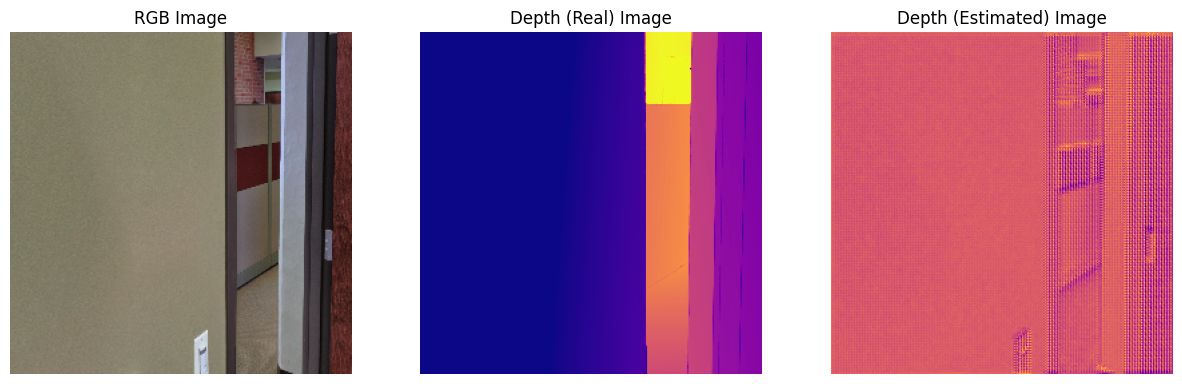

Step: 0k


2023-11-10 07:06:02.238328: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


#[[<tf.Tensor: shape=(), dtype=float32, numpy=54.65637>, <tf.Tensor: shape=(), dtype=float32, numpy=0.87813157>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5377824>, <tf.Tensor: shape=(), dtype=float32, numpy=1.6687174>], [<tf.Tensor: shape=(), dtype=float32, numpy=61.777443>, <tf.Tensor: shape=(), dtype=float32, numpy=0.892427>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6088502>, <tf.Tensor: shape=(), dtype=float32, numpy=1.6997395>], [<tf.Tensor: shape=(), dtype=float32, numpy=67.6367>, <tf.Tensor: shape=(), dtype=float32, numpy=0.87382007>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6676288>, <tf.Tensor: shape=(), dtype=float32, numpy=1.694108>], [<tf.Tensor: shape=(), dtype=float32, numpy=55.539326>, <tf.Tensor: shape=(), dtype=float32, numpy=0.91416675>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5462516>, <tf.Tensor: shape=(), dtype=float32, numpy=1.6831126>], [<tf.Tensor: shape=(), dtype=float32, numpy=68.712135>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8894517>, <

In [29]:
losses = fit(train_dataset, train_dataset, steps=10)
print(losses)

In [30]:
import cv2
def psnr(model, test_input, tar):
  prediction = model(test_input, training=False)

  d = [test_input[0], tar[0], prediction[0]]
  for i in range(3):
    d[i] = d[i] * 0.5 + 0.5
    d[i] = d[i].numpy()
  return cv2.PSNR(d[1], d[2])

def calc():
    psnrs = []
    for example_input, example_target in train_dataset.take(64):
      val = psnr(generator, example_input, example_target)
      psnrs.append(val)
    return np.mean(psnrs)

In [31]:
print("Mean PNSR:", calc())

Mean PNSR: 58.255208671513074
